In [44]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import PIL
from sklearn.cluster import KMeans
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson
from itertools import chain
import matplotlib.cbook as cbook
from matplotlib_scalebar.scalebar import ScaleBar

import numpy
import scipy.cluster.hierarchy as hcluster

# change the following to %matplotlib notebook for interactive plotting
%matplotlib notebook
from scipy.signal import find_peaks
# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims
import trackpy as tp

## import images
V_moving_list=[]


### function to find msd, returns list of msd values and plots the individual particles msds when called

def find_msd(data,max_lag_time):  ## takes in dataframe and a max lag time
    matrix_msd=[] ## to store all particle trajectories (each row a particle trajectory)
    d_t=[]
    ## see all particle numbers that have trajectory 
    part_temp=list(data['particle'])
    part = list(set(part_temp))
    for i in part: ## loop over all trajectories
        del_t=[]
        msd_part_i=[]
        df=data.loc[data['particle'] ==i]  ## dataframe of all rows with particle =i
        x_list=list(df['x'])## x positions of particle i
        y_list=list(df['y'])## y positions of particle i
        for t in range(1,max_lag_time):  ## loop over lag times
            del_t.append(t)
            dx=[(x_list[j+t]-x_list[j]) for j in range(len(x_list)-int(max_lag_time))]
            dy=[(y_list[j+t]-y_list[j]) for j in range(len(y_list)-int(max_lag_time))]
            disp=[np.sqrt(dx[i]**2+dy[i]**2) for i in range(len(dx))] ## find displacement
            msd_temp=np.mean(disp)## mean 
            msd_part_i.append(msd_temp)
        #plt.loglog(del_t,msd_part_i,alpha=0.1,color='black')
        matrix_msd.append(msd_part_i)
        d_t.append(del_t)
        plt.xlabel('lag_time')
        plt.ylabel('msd')
        
        #plt.show() ###shows individual particle msds while calling the function
    matrix_msd_arr = np.array(matrix_msd)
    # delete all the rows with any NaN value( some rows become nan as there are too less trajectory frames compared to max lag time)
    indexList = [np.any(i) for i in np.isnan(matrix_msd_arr )]
    matrix_msd_corrected  = np.delete(matrix_msd_arr , indexList, axis=0)
    msd = np.average(matrix_msd_corrected, axis=0)  ## average columns of the matrix(ie over all positions for a lag time)
    return msd,del_t
    
def find_traj_data(frames,conect,mem,size,mass,filt):
    ## locate features in all frames( fluroscent bleach after 200 frames)
    f = tp.batch(frames[:100],size, minmass=mass); ### locate features with radius 7 and minimum brightness 100 from frame 100

    ## link different frames
    t = tp.link(f,conect, memory=mem) ### features must uptot 5 pixels in the next frame to be considered a trajectory (memory incase it disapears for some frames)

    #### trajectories that last fewer than 30 frames are disguarded
    t1 = tp.filter_stubs(t,filt)
    # Compare the number of particles in the unfiltered and filtered data.
    #print('Before:', t['particle'].nunique())
    #print('After:', t1['particle'].nunique())

     #tp.plot_traj(t1);

    ## subtract any drift in image(look at image from the center of mass)
    d = tp.compute_drift(t1)
    tm = tp.subtract_drift(t1.copy(), d) 
    tm.rename(columns = {'size':'area'}, inplace = True)
    data = pd.DataFrame()

    for item in set(tm.particle):
    
        sub = tm[tm.particle==item]
        
        dx = m_p*np.diff(sub.x)/1. # differnece between to frame for X postion
        dy = m_p*np.diff(sub.y)/1. #wdiffernece between to frame for Y postion
        dt = np.diff(sub.frame)/Fps #to calcul the time
        dr=((np.sqrt(dy**2 + dx**2)))
        tan = (dy/dx) # to calcul the slope
        ang_d=abs((np.arctan(tan)*57.2958))
        #print(np.diff(sub.frame))
        #v = (((np.sqrt(dy**2 + dx**2)))/dt)
        v = (((np.sqrt(dy**2 + dx**2)))/dt)
        
        dx_total=sub.x.tolist()[-1]-sub.x.tolist()[0]
        dy_total=sub.y.tolist()[-1]-sub.y.tolist()[0]
        dt_total=sub.frame.tolist()[-1]-sub.frame.tolist()[0]
        
        #s = [41.7*(((np.sqrt(dy_total**2 + dx_total**2)))/dt_total) for _ in range(len(v))]
        s = [2*41.7*(((np.sqrt(dy_total**2 + dx_total**2)))/dt_total) for _ in range(len(v))]
        
        for x, y, dx, dy,disp, v,s,ang_disp,area, dt, frame in zip(sub.x[:-1], sub.y[:-1], abs(dx), abs(dy),dr ,v,s,ang_d,sub.area[:-1] ,dt,sub.frame[:-1],):
            data = data.append([{'dx': dx,
            'dy': dy,
             'x': x,
             'y': y,
            'frame': frame,
             'particle': item,
              'disp':disp,                  
             'dt' : dt,
             'area':area,
              'ang_disp':ang_disp,  
            's':s,  
             'v' : v,}])
       
    
    
    utraj = np.unique(tm.particle)
    num_traj = utraj.size
    cdict = {}

   
    return tm,data




def find_ee_distance(data):  ## takes in dataframe and a max lag time
    disp_part_i=[]
    xi=[]
    yi=[]
    part_id=[]
    ## see all particle numbers that have trajectory 
    part_temp=list(data['particle'])
    part = list(set(part_temp))
    for i in part: ## loop over all trajectories
        del_t=[]
        msd_part_i=[]
        df=data.loc[data['particle'] ==i]  ## dataframe of all rows with particle =i
        x_list=list(df['x'])## x positions of particle i
        y_list=list(df['y'])## y positions of particle i
        dx=(x_list[0]-x_list[-1])
        dy=(y_list[0]-y_list[-1])
        disp=np.sqrt(dx**2+dy**2) ## find displacement
        disp_part_i.append(disp)
        xi.append(x_list[-1])
        yi.append(y_list[-1])
        part_id.append(i)
    return disp_part_i,xi,yi,part_id

def find_rad_distance(data,xc,yc):  ## takes in dataframe and a max lag time
    disp_part_i=[]
    ri_list=[]
    rf_list=[]
    part_id=[]
    r_list=[]
    ## see all particle numbers that have trajectory 
    part_temp=list(data['particle'])
    part = list(set(part_temp))
    for i in part: ## loop over all trajectories
        del_t=[]
        msd_part_i=[]
        df=data.loc[data['particle'] ==i]  ## dataframe of all rows with particle =i
        r_part_i=[]
        x_list=list(df['x'])## x positions of particle i
        y_list=list(df['y'])## y positions of particle i
        
       
        dxi=(x_list[0]-xc)
        dyi=(y_list[0]-yc)
        dxf=(x_list[-1]-xc)
        dyf=(y_list[-1]-yc)  
        ri=np.sqrt(dxi**2+dyi**2) ## find displacement
        rf=np.sqrt(dxf**2+dyf**2) ## find displacement
        ri_list.append(ri)
        rf_list.append(rf)
        part_id.append(i)
    return ri_list,rf_list,part_id

def find_rad_distance2(data,xc,yc):  ## takes in dataframe and a max lag time
    disp_part_i=[]
    ri_list=[]
    rf_list=[]
    part_id=[]
    r_list=[]
    ## see all particle numbers that have trajectory 
    part_temp=list(data['particle'])
    part = list(set(part_temp))
    for i in part: ## loop over all trajectories
        del_t=[]
        msd_part_i=[]
        df=data.loc[data['particle'] ==i]  ## dataframe of all rows with particle =i
        r_part_i=[]
        x_list=list(df['x'])## x positions of particle i
        y_list=list(df['y'])## y positions of particle i
        for xi,yi in zip(x_list,y_list):
            r_part_i.append(np.sqrt((xi-xc)**2+(yi-yc)**2))
        r_list.append(r_part_i)
        dxi=(x_list[0]-xc)
        dyi=(y_list[0]-yc)
        dxf=(x_list[-1]-xc)
        dyf=(y_list[-1]-yc)  
        ri=np.sqrt(dxi**2+dyi**2) ## find displacement
        rf=np.sqrt(dxf**2+dyf**2) ## find displacement
        ri_list.append(ri)
        rf_list.append(rf)
        part_id.append(i)
    return ri_list,rf_list,part_id,r_list

def in_out(min_dist,ri,rf,xe,ye,ee,iidr,data,frames,rmin,rmax):
    iid_in=[]
    iid_out=[]
    %matplotlib notebook
    V_filtered_list=[]
    fig, ax = plt.subplots()
    ax.axis("off")
    for ind,i in enumerate(iidr):
        
        if ee[ind]>min_dist and ri[ind]>rmin and ri[ind]<rmax:
            #plt.scatter(xe[i],ye[i],color='yellow',s=10)
            df=data.loc[data['particle'] ==i]
            trajx=df['x'].tolist()
            trajy=df['y'].tolist()
            x=trajx
            y=trajy
            c_map = plt.cm.get_cmap('cool')

            # Normalize the color values between 0 and 1
            norm = plt.Normalize(0, len(x) - 1)
    
            # Plot the trajectories with a colormap
            for i in range(len(x) - 1):
                color = c_map(norm(i))
                plt.plot([x[i], x[i+1]], [y[i], y[i+1]], color=color)


            # Add a colorbar to show the fade in between
            sm = plt.cm.ScalarMappable(cmap=c_map, norm=norm)
            sm.set_array([])
            #cbar = plt.colorbar(sm)


            #plt.xlabel('X')
            #plt.ylabel('Y')
            #plt.title('Particle Trajectories')
       
            for i in range(0,len(iidr)):
        
                if ri[i]>rf[i] and ee[i]>min_dist and ri[i]>rmin and ri[i]<rmax:
                    iid_in.append(i)
                
          
                if ri[i]<rf[i] and ee[i]>min_dist and ri[i]>rmin and ri[i]<rmax:
                
                    iid_out.append(i)
         
   


    
    
   
    if (len(iid_out)+len(iid_in))!=0:
        ratio_in_out=len(iid_in)/(len(iid_out)+len(iid_in))
    else:
        ratio_in_out=0
    return ratio_in_out,V_filtered_list
def in_out_view(min_dist,ri,rf,xe,ye,ee,iidr,data,frames,rmin,rmax):
    iid_in=[]
    iid_out=[]
    %matplotlib notebook
    V_filtered_list=[]
    fig, ax = plt.subplots()
    ax.axis("off")
    for ind,i in enumerate(iidr):
        
        if ee[ind]>min_dist and ri[ind]>rmin and ri[ind]<rmax:
            #plt.scatter(xe[i],ye[i],color='yellow',s=10)
            df=data.loc[data['particle'] ==i]
            trajx=df['x'].tolist()
            trajy=df['y'].tolist()
            x=trajx
            y=trajy
            c_map = plt.cm.get_cmap('cool')

            # Normalize the color values between 0 and 1
            norm = plt.Normalize(0, len(x) - 1)
    
            # Plot the trajectories with a colormap
            for i in range(len(x) - 1):
                color = c_map(norm(i))
                plt.plot([x[i], x[i+1]], [y[i], y[i+1]], color=color)


            # Add a colorbar to show the fade in between
            sm = plt.cm.ScalarMappable(cmap=c_map, norm=norm)
            sm.set_array([])
            #cbar = plt.colorbar(sm)


            #plt.xlabel('X')
            #plt.ylabel('Y')
            #plt.title('Particle Trajectories')
       
            for i in range(0,len(iidr)):
        
                if ri[i]>rf[i] and ee[i]>min_dist and ri[i]>rmin and ri[i]<rmax:
                    iid_in.append(i)
                
          
                if ri[i]<rf[i] and ee[i]>min_dist and ri[i]>rmin and ri[i]<rmax:
                
                    iid_out.append(i)
         
    scalebar = ScaleBar(41.7, "nm", scale_loc='bottom', length_fraction=0.25, color='white', box_alpha=0)


    ax.add_artist(scalebar)


    plt.plot()
    sm = plt.cm.ScalarMappable(cmap=c_map, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    plt.imshow(frames[0]);
    if (len(iid_out)+len(iid_in))!=0:
        ratio_in_out=len(iid_in)/(len(iid_out)+len(iid_in))
    else:
        ratio_in_out=0
    return ratio_in_out,V_filtered_list


def in_out_vels(min_dist,ri,rf,xe,ye,ee,iidr,data,frames,rmin,rmax):
    iid_in=[]
    iid_out=[]
    %matplotlib notebook
    V_filtered_list=[]
    V_in=[]
    V_out=[]
    fig, ax = plt.subplots()
    ax.axis("off")
    for ind,i in enumerate(iidr):
        
        if ee[ind]>min_dist and ri[ind]>rmin and ri[ind]<rmax:
            #plt.scatter(xe[i],ye[i],color='yellow',s=10)
            df=data.loc[data['particle'] ==i]
            trajx=df['x'].tolist()
            trajy=df['y'].tolist()
            x=trajx
            y=trajy
            c_map = plt.cm.get_cmap('cool')

            # Normalize the color values between 0 and 1
            norm = plt.Normalize(0, len(x) - 1)
    
            # Plot the trajectories with a colormap
            for i in range(len(x) - 1):
                color = c_map(norm(i))
                plt.plot([x[i], x[i+1]], [y[i], y[i+1]], color=color)


            # Add a colorbar to show the fade in between
            sm = plt.cm.ScalarMappable(cmap=c_map, norm=norm)
            sm.set_array([])
            #cbar = plt.colorbar(sm)


            #plt.xlabel('X')
            #plt.ylabel('Y')
            #plt.title('Particle Trajectories')
       
            for i in range(0,len(iidr)):
        
                if ri[i]>rf[i] and ee[i]>min_dist and ri[i]>rmin and ri[i]<rmax:
                    iid_in.append(i)
                    df=data.loc[data['particle'] ==i]
                    vel=df['v'].tolist()
                    for velocity in vel:
                        V_in.append(velocity)
                    
                
          
                if ri[i]<rf[i] and ee[i]>min_dist and ri[i]>rmin and ri[i]<rmax:
                
                    iid_out.append(i)
                    df=data.loc[data['particle'] ==i]
                    vel=df['v'].tolist()
                    for velocity in vel:
                        V_out.append(velocity)
         
    scalebar = ScaleBar(41.7, "nm", scale_loc='bottom', length_fraction=0.25, color='white', box_alpha=0)


    ax.add_artist(scalebar)


    plt.plot()
    sm = plt.cm.ScalarMappable(cmap=c_map, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    plt.imshow(frames[0]);
    if (len(iid_out)+len(iid_in))!=0:
        ratio_in_out=len(iid_in)/(len(iid_out)+len(iid_in))
    else:
        ratio_in_out=0
    return ratio_in_out,[V_in,V_out]





m_p=2*41.7
Fps=1
def find_cm(frames,tm,size):
    ##finding center of cell, is taking center of mass ok? how to define the center from image?
    f = tp.batch(frames[:2],size, minmass=100); ### locate features with radius 7 and minimum brightness 100 from frame 100
    x_vals=f['x'].tolist()
    y_vals=f['y'].tolist()
    mass=f['raw_mass'].tolist()
    x_cm=0
    y_cm=0
    for i in range(0,len(mass)):## takin
        x_cm+=(x_vals[i]*mass[i])/np.sum(mass)
        y_cm+=(y_vals[i]*mass[i])/np.sum(mass)
    
     
    return x_cm,y_cm

      





In [12]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

data_dir = 'data_r_min' 
image_exts = ['jpeg','jpg', 'bmp', 'png']
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

data = tf.keras.utils.image_dataset_from_directory('data_r_min')


data_iterator = data.as_numpy_iterator()

batch = data_iterator.next()

## scale data for better performance
data = data.map(lambda x,y: (x/255, y))
scaled_iterator=data.as_numpy_iterator()
batch=scaled_iterator.next()


## split data
train_size = int(len(data)*.5)
val_size = int(len(data)*.25)
test_size = int(len(data)*.25)

print(train_size )
print(val_size)
print(test_size)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)


Found 101 files belonging to 4 classes.
2
1
1


In [13]:
### SPECIFY MODEL PARAMETERS #####

model_r = Sequential()
## 16 filters,3x3 pixels in size, stride(window),relu=take output from conv 
#layer into a function 0 for -ve and linear for +ve
model_r.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model_r.add(MaxPooling2D())  ### takes max of 2 pixels to reduce image data for faster processing
model_r.add(Conv2D(16, (3,3), 1, activation='relu'))
model_r.add(MaxPooling2D())
model_r.add(Conv2D(32, (3,3), 1, activation='relu'))
model_r.add(MaxPooling2D())
model_r.add(Flatten())
model_r.add(Dense(256, activation='relu'))
model_r.add(Dense(4, activation='sigmoid'))

model_r.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_r.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 16)      2320      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 30, 30, 32)       

In [14]:
#### TRAIN MODEL #####
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist_r = model_r.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])



Epoch 1/40
2/2 [==============================] - 1s 577ms/step - loss: 1.3538 - accuracy: 0.1875 - val_loss: 1.3594 - val_accuracy: 0.2812
Epoch 2/40
2/2 [==============================] - 1s 540ms/step - loss: 1.2709 - accuracy: 0.4219 - val_loss: 1.0631 - val_accuracy: 0.6562
Epoch 3/40
2/2 [==============================] - 1s 530ms/step - loss: 1.1055 - accuracy: 0.5781 - val_loss: 1.0211 - val_accuracy: 0.5625
Epoch 4/40
2/2 [==============================] - 1s 534ms/step - loss: 0.9654 - accuracy: 0.5781 - val_loss: 0.8347 - val_accuracy: 0.5938
Epoch 5/40
2/2 [==============================] - 1s 533ms/step - loss: 0.8743 - accuracy: 0.5469 - val_loss: 0.7806 - val_accuracy: 0.6250
Epoch 6/40
2/2 [==============================] - 1s 519ms/step - loss: 0.9113 - accuracy: 0.5781 - val_loss: 0.7909 - val_accuracy: 0.6875
Epoch 7/40
2/2 [==============================] - 1s 519ms/step - loss: 0.7675 - accuracy: 0.7031 - val_loss: 0.7267 - val_accuracy: 0.7188
Epoch 8/40
2/2 [====

<IPython.core.display.Javascript object>


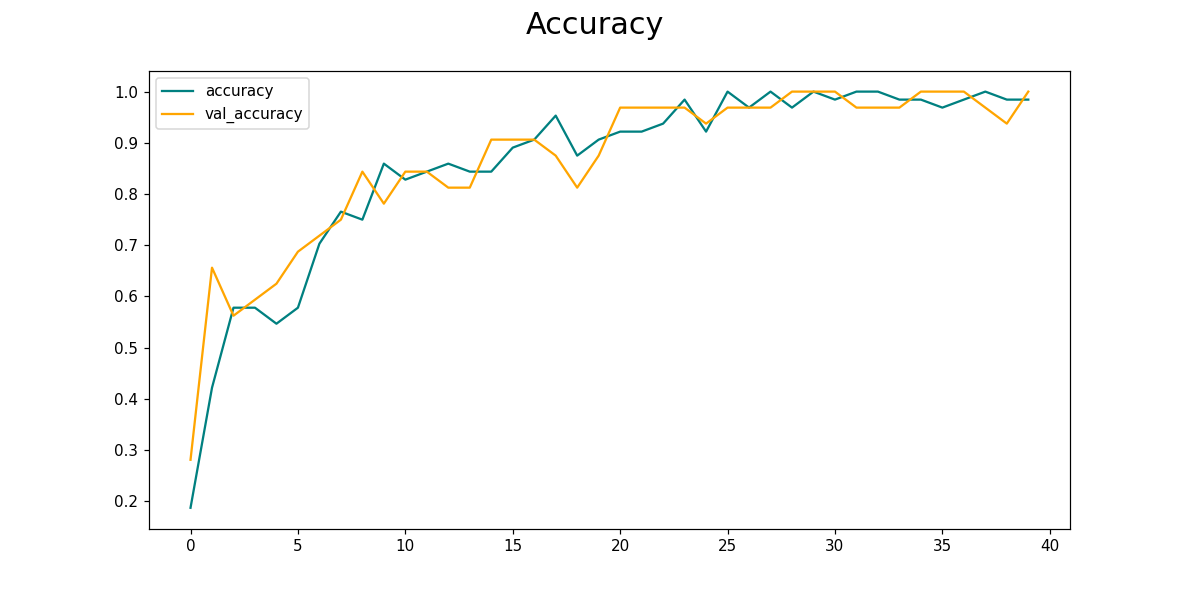

In [15]:
%matplotlib notebook
fig = plt.figure()
plt.plot(hist_r.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist_r.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [16]:
data_dir_2 = 'data_contrast' 
image_exts = ['jpeg','jpg', 'bmp', 'png']
for image_class in os.listdir(data_dir_2): 
    for image in os.listdir(os.path.join(data_dir_2, image_class)):
        image_path = os.path.join(data_dir_2, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

data_2 = tf.keras.utils.image_dataset_from_directory('data_contrast')


data_iterator_2 = data_2.as_numpy_iterator()

batch_2 = data_iterator_2.next()

## scale data for better performance
data_2 = data_2.map(lambda x,y: (x/255, y))
scaled_iterator2=data_2.as_numpy_iterator()
batch2=scaled_iterator2.next()
print('len data',len(data_2))

## split data
train_size = int(len(data_2)*.7)
val_size = int(len(data_2)*.25)
test_size = int(len(data_2)*.25)

print('training set:',train_size )
print('validation',val_size)
print('test',test_size)

train = data_2.take(train_size)
val = data_2.skip(train_size).take(val_size)
test = data_2.skip(train_size+val_size).take(test_size)




Found 180 files belonging to 6 classes.
len data 6
training set: 4
validation 1
test 1


In [17]:
### SPECIFY MODEL PARAMETERS #####

model_c = Sequential()
## 16 filters,3x3 pixels in size, stride(window),relu=take output from conv 
#layer into a function 0 for -ve and linear for +ve
model_c.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model_c.add(MaxPooling2D())  ### takes max of 2 pixels to reduce image data for faster processing
model_c.add(Conv2D(16, (2,2), 1, activation='relu'))
model_c.add(MaxPooling2D())
model_c.add(Conv2D(32, (2,2), 1, activation='relu'))
model_c.add(MaxPooling2D())
model_c.add(Flatten())
model_c.add(Dense(256, activation='relu'))
model_c.add(Dense(6, activation='sigmoid'))

model_c.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_c.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 126, 126, 16)      1040      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 63, 63, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 62, 62, 32)        2080      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 31, 31, 32)       

In [18]:
#### TRAIN MODEL #####
logdir='logs'
tensorboard_callback_c = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist_c = model_c.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])




Epoch 1/40
4/4 [==============================] - 2s 441ms/step - loss: 1.7535 - accuracy: 0.2109 - val_loss: 1.4370 - val_accuracy: 0.4062
Epoch 2/40
4/4 [==============================] - 2s 421ms/step - loss: 1.3989 - accuracy: 0.4062 - val_loss: 1.3504 - val_accuracy: 0.5000
Epoch 3/40
4/4 [==============================] - 2s 434ms/step - loss: 1.1289 - accuracy: 0.5625 - val_loss: 0.9858 - val_accuracy: 0.5312
Epoch 4/40
4/4 [==============================] - 2s 422ms/step - loss: 1.0298 - accuracy: 0.5781 - val_loss: 0.9713 - val_accuracy: 0.7188
Epoch 5/40
4/4 [==============================] - 2s 427ms/step - loss: 1.0158 - accuracy: 0.5938 - val_loss: 0.7649 - val_accuracy: 0.7812
Epoch 6/40
4/4 [==============================] - 2s 423ms/step - loss: 0.8718 - accuracy: 0.6328 - val_loss: 0.7791 - val_accuracy: 0.7188
Epoch 7/40
4/4 [==============================] - 2s 426ms/step - loss: 0.6546 - accuracy: 0.7344 - val_loss: 0.7884 - val_accuracy: 0.6875
Epoch 8/40
4/4 [====

<IPython.core.display.Javascript object>


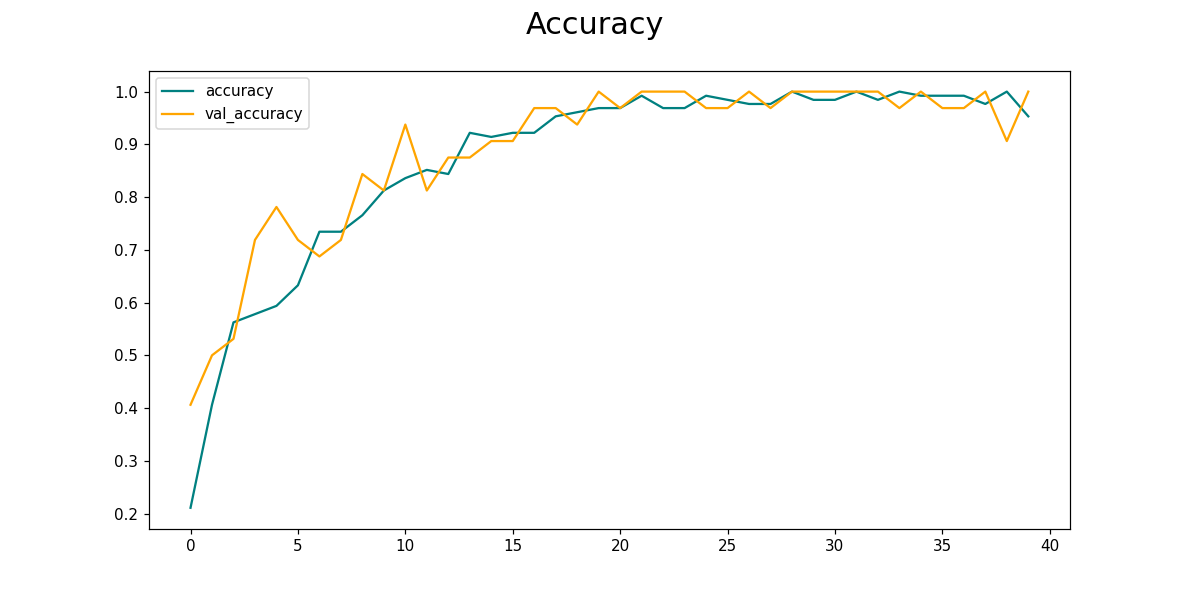

In [19]:
%matplotlib notebook
fig = plt.figure()
plt.plot(hist_c.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist_c.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()


In [22]:
data_dir_gb = 'data' ## data_good or bad(gb)
image_exts = ['jpeg','jpg', 'bmp', 'png']
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

data_gb = tf.keras.utils.image_dataset_from_directory('data')


data_iterator_gb = data_gb.as_numpy_iterator()

batch_gb = data_iterator_gb.next()

## scale data for better performance
data_gb = data_gb.map(lambda x,y: (x/255, y))
scaled_iterator_gb=data_gb.as_numpy_iterator()
batch_gb=scaled_iterator_gb.next()
print('number of groups',len(data))
## split data
train_size = int(len(data)*.50)
val_size = int(len(data)*.25)
test_size = int(len(data)*.25)


train = data_gb.take(train_size)
val = data_gb.skip(train_size).take(val_size)
test = data_gb.skip(train_size+val_size).take(test_size)


### SPECIFY MODEL PARAMETERS #####

model_gb = Sequential()
## 16 filters,3x3 pixels in size, stride(window),relu=take output from conv 
#layer into a function 0 for -ve and linear for +ve
model_gb.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model_gb.add(MaxPooling2D())  ### takes max of 2 pixels to reduce image data for faster processing
model_gb.add(Conv2D(32, (3,3), 1, activation='relu'))
model_gb.add(MaxPooling2D())
model_gb.add(Conv2D(16, (3,3), 1, activation='relu'))
model_gb.add(MaxPooling2D())
model_gb.add(Flatten())
model_gb.add(Dense(256, activation='relu'))
model_gb.add(Dense(1, activation='sigmoid'))

model_gb.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

#### TRAIN MODEL #####
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model_gb.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Found 102 files belonging to 2 classes.
number of groups 4
Epoch 1/20
2/2 [==============================] - 1s 608ms/step - loss: 0.6719 - accuracy: 0.6250 - val_loss: 0.6157 - val_accuracy: 0.7188
Epoch 2/20
2/2 [==============================] - 1s 560ms/step - loss: 0.5616 - accuracy: 0.7188 - val_loss: 0.5154 - val_accuracy: 0.8750
Epoch 3/20
2/2 [==============================] - 1s 529ms/step - loss: 0.5386 - accuracy: 0.7812 - val_loss: 0.4752 - val_accuracy: 0.8438
Epoch 4/20
2/2 [==============================] - 1s 528ms/step - loss: 0.4294 - accuracy: 0.8594 - val_loss: 0.3557 - val_accuracy: 0.9062
Epoch 5/20
2/2 [==============================] - 1s 528ms/step - loss: 0.4722 - accuracy: 0.8281 - val_loss: 0.3307 - val_accuracy: 0.9062
Epoch 6/20
2/2 [==============================] - 1s 545ms/step - loss: 0.3153 - accuracy: 0.8906 - val_loss: 0.2483 - val_accuracy: 0.9062
Epoch 7/20
2/2 [==============================] - 1s 533ms/step - loss: 0.2420 - accuracy: 0.8750 - v

In [23]:
### Evaluate ######
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
pre = Precision()
re = Recall()
acc = BinaryAccuracy()
for batch in test.as_numpy_iterator(): 
    X, y = batch_gb
    yhat = model_gb.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
print(pre.result(), re.result(), acc.result())

1/1 [==============================] - 0s 104ms/step
tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.8695652, shape=(), dtype=float32) tf.Tensor(0.90625, shape=(), dtype=float32)


In [24]:
#### TEST #####
import cv2
import numpy as np

%matplotlib notebook
#img = cv2.imread('J_wt6.jpg')
#img = cv2.imread('unusable.jpg')
#img = cv2.imread('J_wt4.jpg')
#img = cv2.imread('m_wt1.jpg')
#img = cv2.imread('J_wt1.jpg')
#img = cv2.imread('high_contrast.jpg')
img = cv2.imread('high_contrast3.jpg')
#img = cv2.imread('m_wt2.jpg')
resize = tf.image.resize(img, (256,256))
#plt.imshow(resize.numpy().astype(int))
#plt.show()


# Convert  to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Threshold the grayscale image to create a binary mask
_, binary_mask = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)

# Calculate the moments of the binary mask to find the center of mass
moments = cv2.moments(binary_mask)
cx = int(moments['m10'] / moments['m00'])
cy = int(moments['m01'] / moments['m00'])

print(cx,cy)
def find_contrast(filename):
    img = cv2.imread(filename)
    #img = cv2.imread('m_wt2.jpg')
    resize = tf.image.resize(img, (256,256))
    #plt.imshow(resize.numpy().astype(int))
    #plt.show()


    # Convert  to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Threshold the grayscale image to create a binary mask
    _, binary_mask = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)

   
    yhat_contrast = model_c.predict(np.expand_dims(resize/255, 0))
    print(yhat_contrast)
    list1_yhat_contrast=yhat_contrast[0].tolist()  # list of probabilities the image is classified into
    contrast=list1_yhat_contrast.index(max(list1_yhat_contrast))
    if contrast==0:
        c=128
        print('contrast=',c)
    if contrast==1:
        c=136
        print('contrast=',c)
    if contrast==2:
        c=145
        print('contrast=',c)
    if contrast==3:
        c=150
        print('contrast=',c)
    if contrast==4:
        c=160
        print('contrast=',c)
    if contrast==5:
        c=170
        print('contrast=',c)

    activation_c=[0 for _ in range(len(yhat_contrast[0]))]    
    for i in range(len(yhat_contrast[0])):
    
        if yhat_contrast[0][i]>0.8:
            activation_c[i]=1
        
    #normalised_contrast=(activation_c[0]*list1_yhat_contrast[0]*128+activation_c[1]*list1_yhat_contrast[1]*136+activation_c[2]*list1_yhat_contrast[2]*145+activation_c[3]*list1_yhat_contrast[3]*150+activation_c[4]*list1_yhat_contrast[4]*160+activation_c[5]*list1_yhat_contrast[5]*170)/activation_c.count(1)
    return c
def csmac_radius(filename):
    img = cv2.imread(filename)
    #img = cv2.imread('m_wt2.jpg')
    resize = tf.image.resize(img, (256,256))
    #plt.imshow(resize.numpy().astype(int))
    #plt.show()


    # Convert  to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Threshold the grayscale image to create a binary mask
    _, binary_mask = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)

    # Calculate the moments of the binary mask to find the center of mass
    moments = cv2.moments(binary_mask)
    cx = int(moments['m10'] / moments['m00'])
    cy = int(moments['m01'] / moments['m00'])

    yhat_radius = model_r.predict(np.expand_dims(resize/255, 0))
    print(yhat_radius)
    list1_radius=yhat_radius[0].tolist()
    radius=list1_radius.index(max(list1_radius))
    if radius==0:
        r=10
        print('radius=',r)
    if radius==1:
        r=20
        print('radius=',r)
    if radius==2:
        r=30
        print('radius=',r)
    if radius==3:
        r=50
        print('radius=',r)

    activation_r=[0 for _ in range(len(yhat_radius[0]))]    
    for i in range(len(yhat_radius[0])):
    
        if yhat_radius[0][i]>0.9:
            activation_r[i]=1
        
    
    if activation_r.count(1)==0:
        return  r
    else:
        normalised_r=(activation_r[0]*list1_radius[0]*10+activation_r[1]*list1_radius[1]*20+activation_r[2]*list1_radius[2]*30+activation_r[3]*list1_radius[3]*50)/activation_r.count(1)
        print('r_norm=',normalised_r)
        return normalised_r
    
def is_img_usable(filename):
    img = cv2.imread(filename)
    

    # Convert  to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    yhat = model_gb.predict(np.expand_dims(resize/255, 0))
    print(yhat)
    if yhat > 0.5: 
        return 1
    else:
        return 0
  




286 252


1/1 [==============================] - 0s 37ms/step
[[2.9895748e-22 3.1409101e-05 7.1803210e-05 9.0041465e-01 9.9999994e-01
  1.0000000e+00]]
contrast= 170


<IPython.core.display.Javascript object>


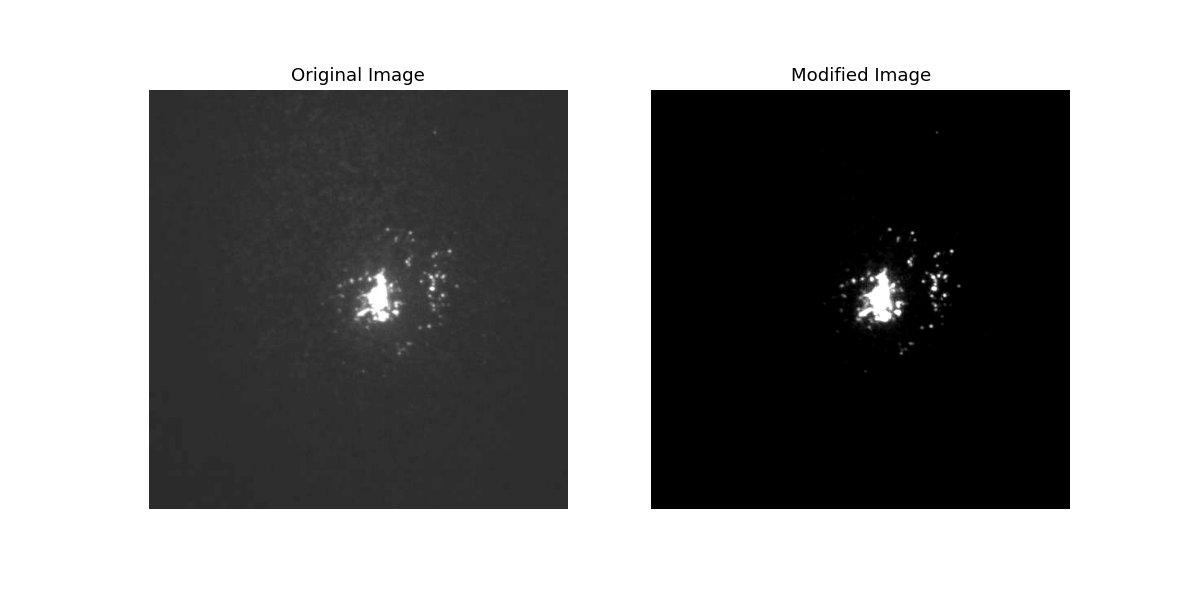

In [25]:
import cv2
%matplotlib notebook

def BrightnessContrast(filename,brightness, contrast,image_no,show):
    img = cv2.imread(filename)
    effect = controller(img, brightness, contrast)
    
    if show==1:
        fig,axs=plt.subplots(1,2,figsize=(10,5))
        axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))     
        axs[0].set_title('Original Image')     
        axs[0].axis('off')
    
        axs[1].imshow(cv2.cvtColor(effect, cv2.COLOR_BGR2RGB))     
        axs[1].set_title('Modified Image')     
        axs[1].axis('off')

    gray = cv2.cvtColor(effect, cv2.COLOR_BGR2GRAY)
    #plt.imshow('Effect', effect)
    if not os.path.exists('image_clear'):
        os.makedirs('image_clear')

    # Save the effect image in the 'image_clear' folder with a sequential number
    output_path = os.path.join('image_clear', f'processed_image_{image_no}.jpg')
    cv2.imwrite(output_path,  gray)

    # Increment the image number for the next iteration
    #image_number += 1

    #plt.show()
    return effect

def controller(img, brightness=255, contrast=127):
    brightness = int((brightness - 0) * (255 - (-255)) / (510 - 0) + (-255))
    contrast = int((contrast - 0) * (127 - (-127)) / (254 - 0) + (-127))

    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            max = 255
        else:
            shadow = 0
            max = 255 + brightness

        al_pha = (max - shadow) / 255
        ga_mma = shadow
        cal = cv2.addWeighted(img, al_pha, img, 0, ga_mma)
    else:
        cal = img

    if contrast != 0:
        Alpha = float(131 * (contrast + 127)) / (127 * (131 - contrast))
        Gamma = 127 * (1 - Alpha)
        cal = cv2.addWeighted(cal, Alpha, cal, 0, Gamma)

    #cv2.putText(cal, 'B:{},C:{}'.format(brightness, contrast), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    return cal


c=find_contrast('high_contrast3.jpg')
if __name__ == '__main__':
    original = img
    img_new = original.copy()

    # Set the brightness and contrast values here
    brightness_value = 255  # Adjust as needed (-255 to 255)
    contrast_value = c    # Adjust as needed (-127 to 127)

    BrightnessContrast('high_contrast3.jpg',brightness_value, contrast_value,1,1)
    


1/1 [==============================] - 0s 14ms/step
[[2.9895748e-22 3.1409101e-05 7.1803210e-05 9.0041465e-01 9.9999994e-01
  1.0000000e+00]]
contrast= 170


<IPython.core.display.Javascript object>


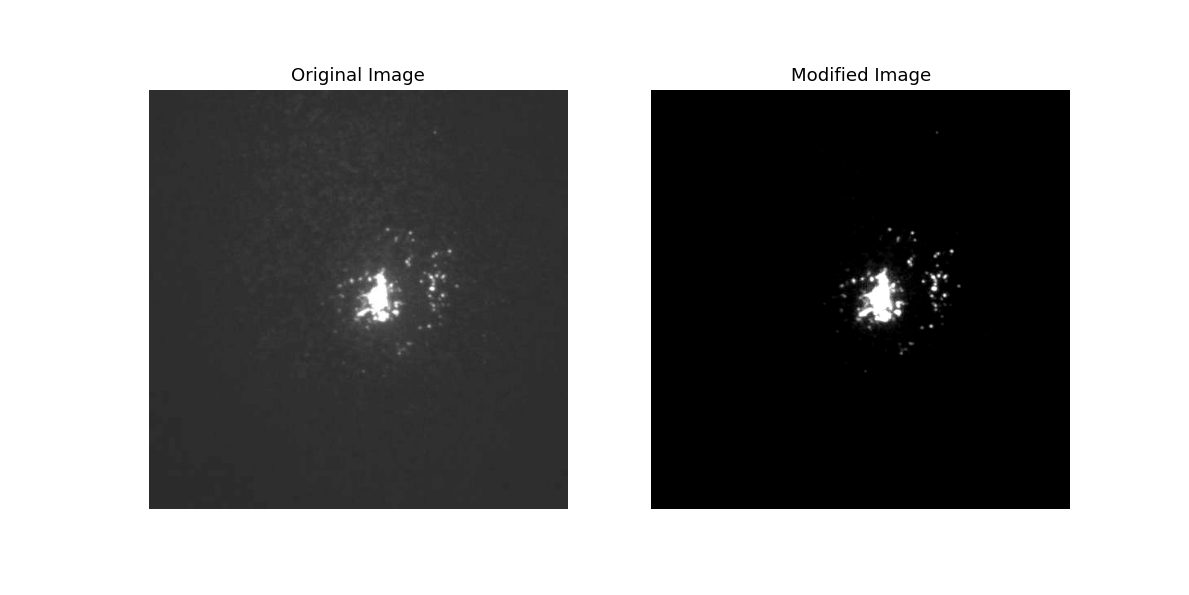

<IPython.core.display.Javascript object>


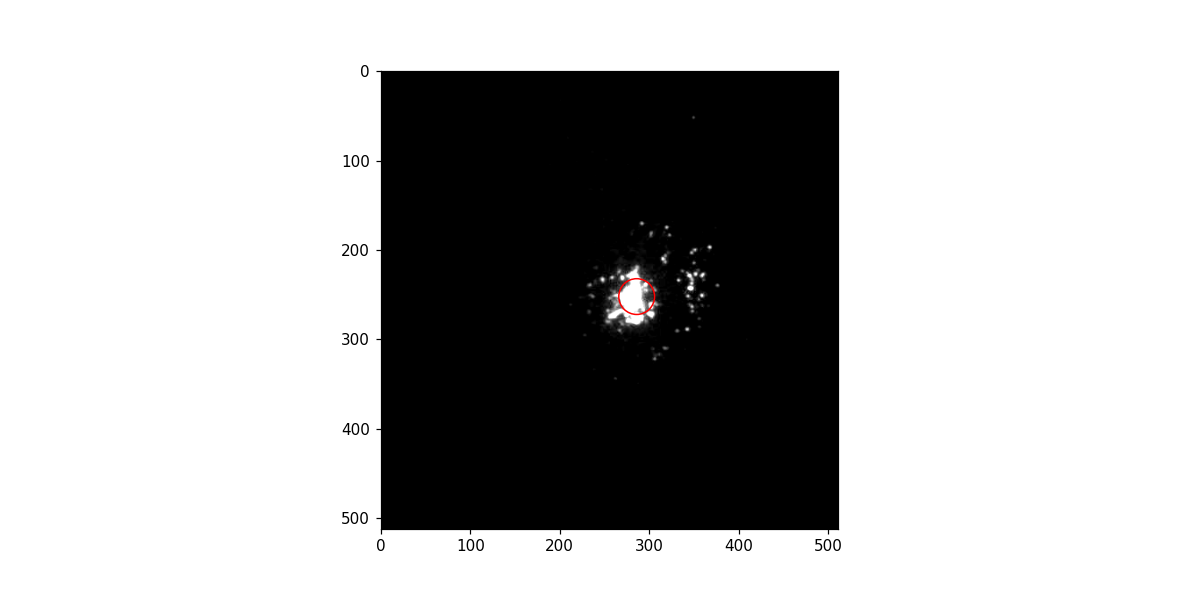

1/1 [==============================] - 0s 40ms/step
[[9.9999911e-01 1.2464853e-01 1.0000000e+00 2.9862803e-11]]
radius= 30
r_norm= 19.999995529651642


In [26]:
#%matplotlib notebook
final_img=BrightnessContrast('high_contrast3.jpg',255, find_contrast('high_contrast3.jpg'),1,1)
figure, axes = plt.subplots()
r=csmac_radius('high_contrast3.jpg')
Drawing_uncolored_circle1 = plt.Circle( (cx, cy ),r,fill = False,color='r')

axes.add_artist( Drawing_uncolored_circle1 )

plt.imshow(final_img)
plt.show()

In [76]:

folder_path = '5'  # Change to your folder path


file_list = os.listdir(folder_path)


image_files = [f for f in file_list if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
sorted_image_files = sorted(image_files)
# Loop through the image files and print their names
for count,image_file in enumerate(sorted_image_files):
    
    print(count)
    image_path = os.path.join(folder_path, image_file)
    if count==1:
        rmin=csmac_radius(image_path)
    print(image_path)
    c=find_contrast(image_path)
    
    # Set the brightness and contrast values here
    
    brightness_value = 255  # Adjust as needed (-255 to 255)
    contrast_value = c    # Adjust as needed (-127 to 127)
    
    final_img=BrightnessContrast(image_path,brightness_value, contrast_value,count,0)
    if count==200:
        print('done')
        break
    


    
    

0
5/TCR-10000.jpg
1/1 [==============================] - 0s 15ms/step
[[9.9961466e-01 4.7009151e-05 9.9999982e-01 9.9958700e-01 8.0731873e-08
  1.6437625e-04]]
contrast= 145
1
1/1 [==============================] - 0s 15ms/step
[[3.120584e-10 4.294879e-06 1.000000e+00 9.950731e-01]]
radius= 30
r_norm= 39.876827001571655
5/TCR-10001.jpg
1/1 [==============================] - 0s 17ms/step
[[9.9973905e-01 1.8006594e-04 9.9999976e-01 9.9933463e-01 1.9728753e-07
  1.0055346e-04]]
contrast= 145
2
5/TCR-10002.jpg
1/1 [==============================] - 0s 15ms/step
[[9.9997246e-01 2.4370175e-04 9.9999982e-01 9.8552769e-01 3.5939124e-07
  8.5319240e-05]]
contrast= 145
3
5/TCR-10003.jpg
1/1 [==============================] - 0s 15ms/step
[[9.9928814e-01 2.6823634e-05 9.9999994e-01 9.9978077e-01 7.7636855e-08
  1.1657479e-04]]
contrast= 145
4
5/TCR-10004.jpg
1/1 [==============================] - 0s 14ms/step
[[9.9974740e-01 3.6296740e-05 1.0000000e+00 9.9845153e-01 1.8248794e-07
  1.2546654e-04]

1/1 [==============================] - 0s 13ms/step
[[9.9997884e-01 3.5042427e-03 9.9999523e-01 9.8930734e-01 4.0234445e-07
  1.1553741e-04]]
contrast= 145
47
5/TCR-10047.jpg
1/1 [==============================] - 0s 13ms/step
[[9.9999529e-01 1.8696925e-03 9.9999899e-01 9.3712348e-01 3.9508012e-07
  6.7335750e-05]]
contrast= 145
48
5/TCR-10048.jpg
1/1 [==============================] - 0s 15ms/step
[[9.9997181e-01 4.9361226e-04 9.9999970e-01 9.9233425e-01 1.3408038e-07
  7.9730467e-05]]
contrast= 145
49
5/TCR-10049.jpg
1/1 [==============================] - 0s 13ms/step
[[9.9999624e-01 5.0236279e-04 9.9999976e-01 9.4046336e-01 1.7126146e-07
  7.2901872e-05]]
contrast= 145
50
5/TCR-10050.jpg
1/1 [==============================] - 0s 13ms/step
[[9.9998778e-01 1.6518601e-03 9.9999964e-01 9.5534432e-01 3.5814480e-07
  5.8071721e-05]]
contrast= 145
51
5/TCR-10051.jpg
1/1 [==============================] - 0s 13ms/step
[[9.9999785e-01 2.5600952e-03 9.9999923e-01 8.7996978e-01 3.6130334e-07
 

1/1 [==============================] - 0s 13ms/step
[[9.9999839e-01 1.2792861e-03 9.9999976e-01 8.3932513e-01 2.0433217e-07
  4.6740901e-05]]
contrast= 145
94
5/TCR-10094.jpg
1/1 [==============================] - 0s 13ms/step
[[9.9999654e-01 2.2804553e-03 9.9999881e-01 9.5424801e-01 1.9124991e-07
  6.7713212e-05]]
contrast= 145
95
5/TCR-10095.jpg
1/1 [==============================] - 0s 13ms/step
[[9.9999970e-01 2.3938781e-03 9.9999970e-01 5.2234852e-01 1.7253886e-07
  3.9292190e-05]]
contrast= 128
96
5/TCR-10096.jpg
1/1 [==============================] - 0s 13ms/step
[[9.9999923e-01 6.2301336e-03 9.9999481e-01 8.2058555e-01 3.7553303e-07
  5.9950551e-05]]
contrast= 128
97
5/TCR-10097.jpg
1/1 [==============================] - 0s 15ms/step
[[9.9999964e-01 8.0333250e-03 9.9999678e-01 6.4254731e-01 4.4170434e-07
  3.2682408e-05]]
contrast= 128
98
5/TCR-10098.jpg
1/1 [==============================] - 0s 13ms/step
[[9.9999958e-01 1.4097778e-02 9.9999040e-01 4.7883791e-01 1.2472202e-06
 

1/1 [==============================] - 0s 14ms/step
[[9.9999994e-01 3.9096707e-03 9.9999833e-01 4.9198577e-01 1.9113668e-07
  4.0286093e-05]]
contrast= 128
141
5/TCR-10141.jpg
1/1 [==============================] - 0s 13ms/step
[[9.9999970e-01 2.2973731e-02 9.9997002e-01 4.4186619e-01 1.1693064e-06
  7.4678261e-05]]
contrast= 128
142
5/TCR-10142.jpg
1/1 [==============================] - 0s 13ms/step
[[9.9999988e-01 1.4226906e-02 9.9997497e-01 4.0450957e-01 7.4243070e-07
  6.7052453e-05]]
contrast= 128
143
5/TCR-10143.jpg
1/1 [==============================] - 0s 14ms/step
[[9.9999976e-01 2.4677970e-02 9.9993688e-01 5.6810057e-01 1.1317150e-06
  8.7434099e-05]]
contrast= 128
144
5/TCR-10144.jpg
1/1 [==============================] - 0s 14ms/step
[[9.9999946e-01 1.0899900e-02 9.9997222e-01 8.1492448e-01 6.6850026e-07
  8.1519320e-05]]
contrast= 128
145
5/TCR-10145.jpg
1/1 [==============================] - 0s 14ms/step
[[9.9999899e-01 2.3205649e-02 9.9993408e-01 6.6267103e-01 1.7616430e

1/1 [==============================] - 0s 17ms/step
[[9.9999976e-01 7.9017274e-02 9.9984264e-01 3.2131758e-01 3.5468433e-06
  7.4172160e-05]]
contrast= 128
188
5/TCR-10188.jpg
1/1 [==============================] - 0s 13ms/step
[[9.9999964e-01 2.0919673e-01 9.9941528e-01 2.8056741e-01 4.7074018e-06
  1.4685652e-04]]
contrast= 128
189
5/TCR-10189.jpg
1/1 [==============================] - 0s 15ms/step
[[9.9999911e-01 1.2471791e-01 9.9961025e-01 6.7508787e-01 3.5332546e-06
  8.0989106e-05]]
contrast= 128
190
5/TCR-10190.jpg
1/1 [==============================] - 0s 14ms/step
[[9.9999911e-01 7.2820440e-02 9.9964517e-01 5.6971669e-01 4.0416026e-06
  2.4793611e-04]]
contrast= 128
191
5/TCR-10191.jpg
1/1 [==============================] - 0s 14ms/step
[[9.9999774e-01 4.1927469e-01 9.9828482e-01 4.5989576e-01 1.2332846e-05
  2.0293819e-04]]
contrast= 128
192
5/TCR-10192.jpg
1/1 [==============================] - 0s 14ms/step
[[9.9999970e-01 2.4915034e-02 9.9997628e-01 6.2585491e-01 9.6828421e

In [ ]:
### 1-11 jurkat wt 12-21 m_wt   22-27 waspneg

Frame 1: 34 features
309.0464283700399 234.24055441886566


<IPython.core.display.Javascript object>


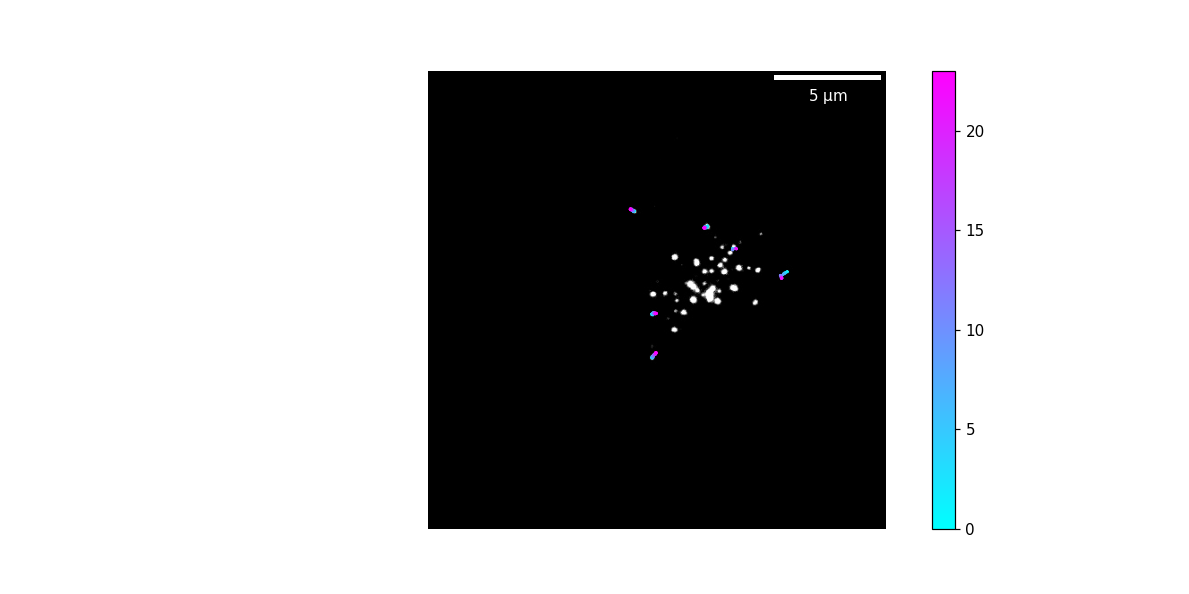

[0.6666666666666666]


<IPython.core.display.Javascript object>


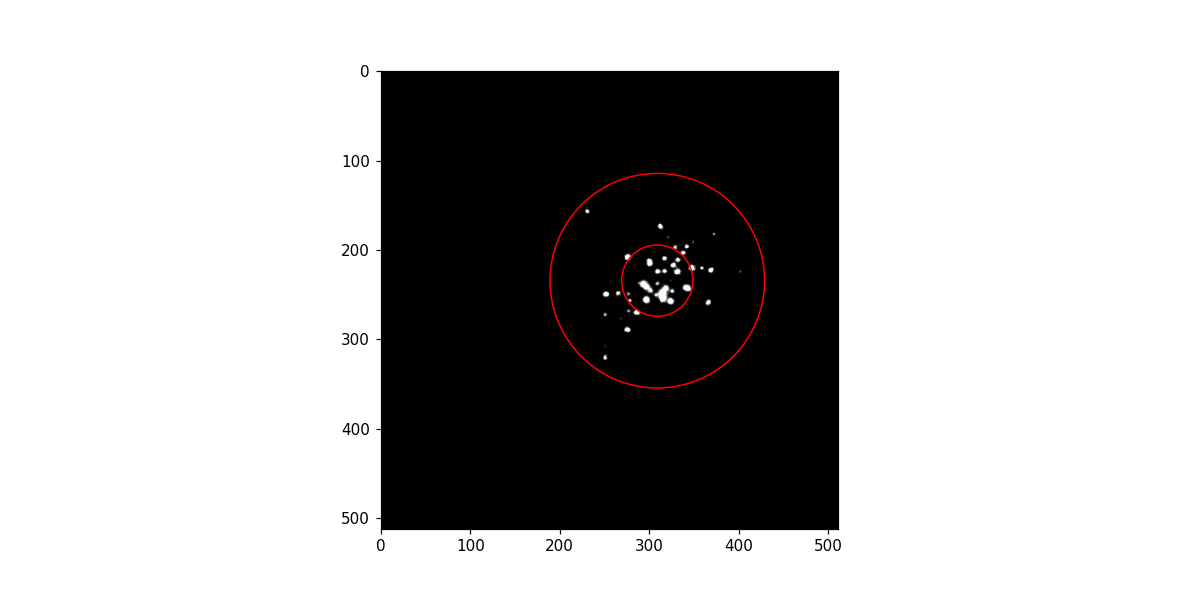

318.5908300667107
0.019769952781343785


/home/samuel/anaconda3/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


In [77]:
# Load your frames and set other parameters
conect = 4
mem = 5
size = 7
mass = 40
filt = 7
ee_cut=3.5
ratio_list=[]
frames = pims.open('image_clear/*.jpg')

ratios=[]
fig, ax = plt.subplots()
ax.axis("off")

n = 1
f = tp.locate(frames[n], size, minmass=mass)
plt.imshow(frames[n])
tp.annotate(f, frames[n],plot_style={'markersize':10})
# Create a white scale bar with a smaller width
rmax=120

tm,data=find_traj_data(frames,conect,mem,size,mass,filt)

ee,xe,ye,iid=find_ee_distance(data)
x_cm,y_cm=find_cm(frames,tm,size)
plt.scatter(x_cm,y_cm,s=10,color='r')
print(x_cm,y_cm)
ri,rf,iidr=find_rad_distance(data,x_cm,y_cm)
ratio,V=in_out_view(ee_cut,ri,rf,xe,ye,ee,iidr,data,frames,rmin,rmax)   
ratio_list.append(ratio)
print(ratio_list)
ratios.append(ratio_list[0])
label.append('Jurkat WT')


figure, axes = plt.subplots()
Drawing_uncolored_circle1 = plt.Circle( (x_cm, y_cm ),rmin,fill = False,color='r')
Drawing_uncolored_circle2 = plt.Circle( (x_cm, y_cm ),rmax,fill = False,color='r')
axes.add_artist( Drawing_uncolored_circle1 )
axes.add_artist( Drawing_uncolored_circle2 )
plt.imshow(frames[0])

#%matplotlib notebook
Vel=data['v'].tolist()
y, x, _ = plt.hist(Vel,40,density=True)
vel_avg.append(np.mean(Vel))
print (x.max())
print(y.max())
x_max=x[np.where(y == y.max())]

vel_list.append(x_max)

y2, x2, _ = plt.hist(V,40,density=True)


x2_max=x2[np.where(y2 == y2.max())]
V_moving_list.append(x2_max)



Frame 1: 8 features


<IPython.core.display.Javascript object>


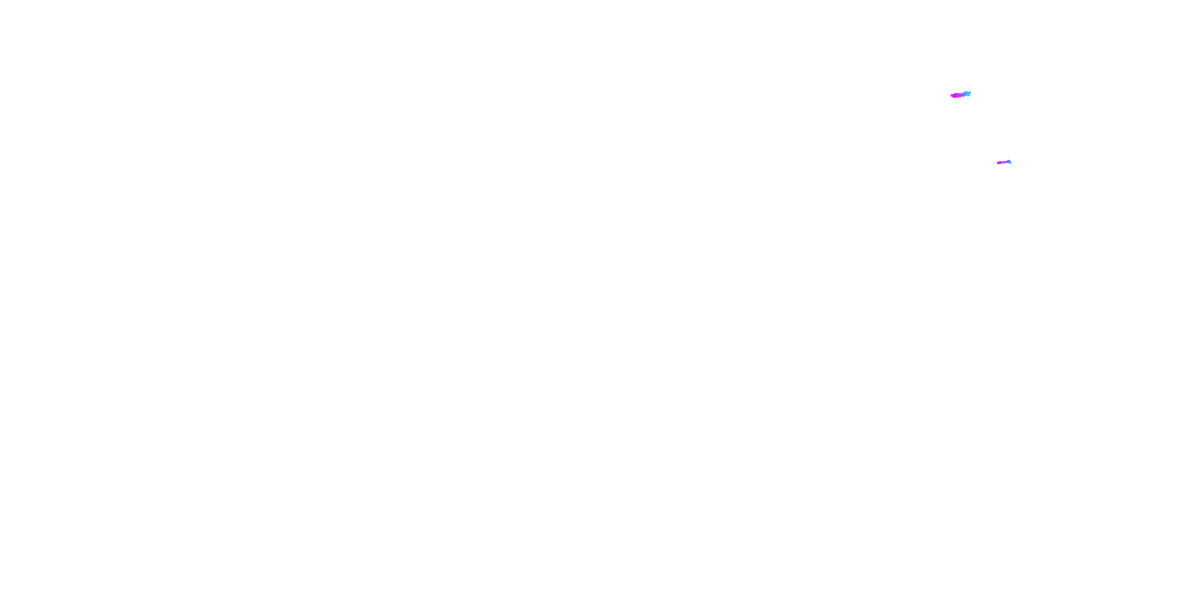

/home/samuel/anaconda3/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
100%|███████████████████████████████████████████| 27/27 [06:58<00:00, 15.49s/it]

277.3280007274943
0.023770882805072464


In [81]:
from tqdm import tqdm
vel_avg=[]

files=np.arange(1,28).tolist()



ratios=[]
vel_list=[]
label=[]
vel_avg=[]

conect = 4 ## search 4 pixels area around the particle at t=0 for next time step
mem = 5 ## incase particle disapears in next time due to noise
size = 7 ## size of particle(kept smallest)
mass = 40 # intensity
filt = 7 ## if particle trajectories<7 frames long is disguarded
ee_cut=3.5 ## if final traj has end-end dist less than this remove it (this is to remove stuck particles)

for i in tqdm(files):
    print(i)
    
    folder_path = f'{i}' 
    if i>=1 and i<= 11:
        label.append('Jurkat wt')
    if i>=12 and i<=21 :
        label.append('Primary wt')
    if i>=22 and i<=27 :
        label.append('Primary Wasp-neg')
    file_list = os.listdir(folder_path)
    image_files = [f for f in file_list if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    sorted_image_files = sorted(image_files)
    
    # Loop through the image files and print their names
    for count,image_file in enumerate(sorted_image_files):
        
        
        image_path = os.path.join(folder_path, image_file)
        if count==1:
            rmin=csmac_radius(image_path)  #### get Rmin
            usable=is_img_usable(image_path)
            
                        
        print(image_path)
        c=find_contrast(image_path)
    
        # Set the brightness and contrast values here, keeb brighness constant
        brightness_value = 255  # Adjust as needed (-255 to 255)
        contrast_value = c    # Adjust as needed (-127 to 127)
         
        final_img=BrightnessContrast(image_path,brightness_value, contrast_value,count,0)
        if count==200:
            break
            
    # Load your frames and set other parameters
   
    ratio_list=[]
    frames = pims.open('image_clear/*.jpg')
    
    fig, ax = plt.subplots()
    ax.axis("off")
    n = 1
    f = tp.locate(frames[n], size, minmass=mass)
    #plt.imshow(frames[n])
    tp.annotate(f, frames[n],plot_style={'markersize':10})
    # Create a white scale bar with a smaller width
    rmax=100

    tm,data=find_traj_data(frames,conect,mem,size,mass,filt)

    ee,xe,ye,iid=find_ee_distance(data)
    x_cm,y_cm=find_cm(frames,tm,size)
    plt.scatter(x_cm,y_cm,s=10,color='r')
   
    ri,rf,iidr=find_rad_distance(data,x_cm,y_cm)
    ratio,V=in_out(ee_cut,ri,rf,xe,ye,ee,iidr,data,frames,rmin,rmax)   
    ratio_list.append(ratio)
    if ratio_list[0]!=0:
        ratios.append(ratio_list[0])
    
    #%matplotlib notebook
    Vel=data['v'].tolist()
    y, x, _ = plt.hist(Vel,40,density=True)
    vel_avg.append(np.mean(Vel))
    print (x.max())
    print(y.max())
    x_max=x[np.where(y == y.max())]

    vel_list.append(x_max)

    y2, x2, _ = plt.hist(V,40,density=True)
    x2_max=x2[np.where(y2 == y2.max())]
    V_moving_list.append(x2_max)

    

    
    
    

In [79]:
print(ratios)

[0.8888888888888888, 0.6923076923076923, 1.0, 0.8571428571428571, 0.75, 0.7142857142857143, 1.0, 0.5, 1.0, 0.5, 1.0, 1.0, 0.4, 0.5876288659793815, 0.3870967741935484, 0.7142857142857143, 0.7575757575757576, 0.4, 0.4]


<IPython.core.display.Javascript object>


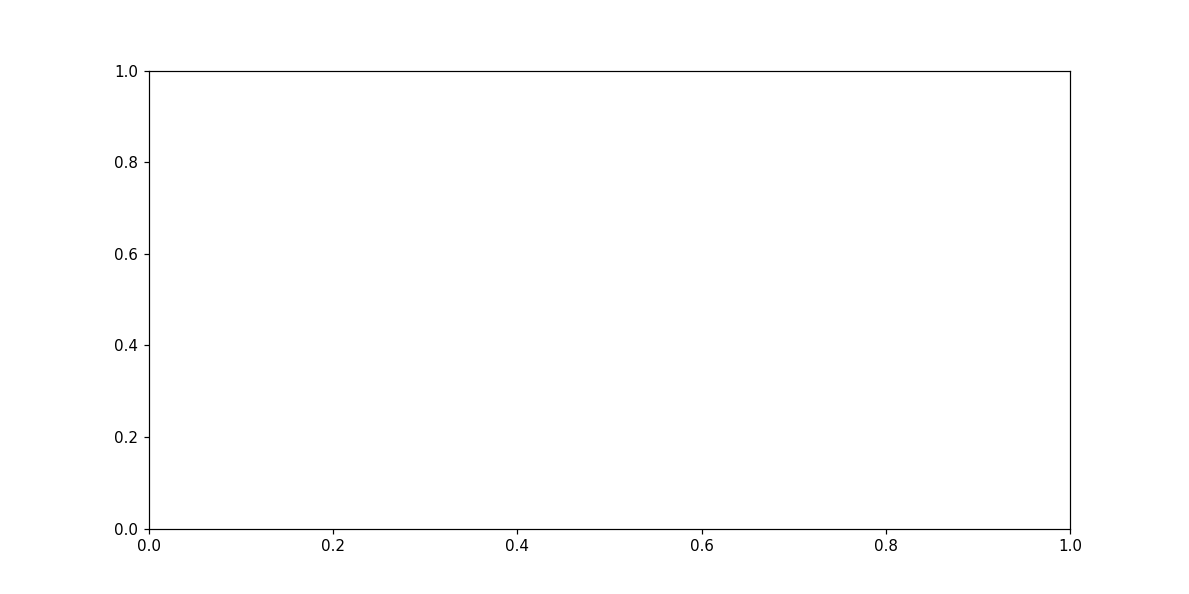

<IPython.core.display.Javascript object>


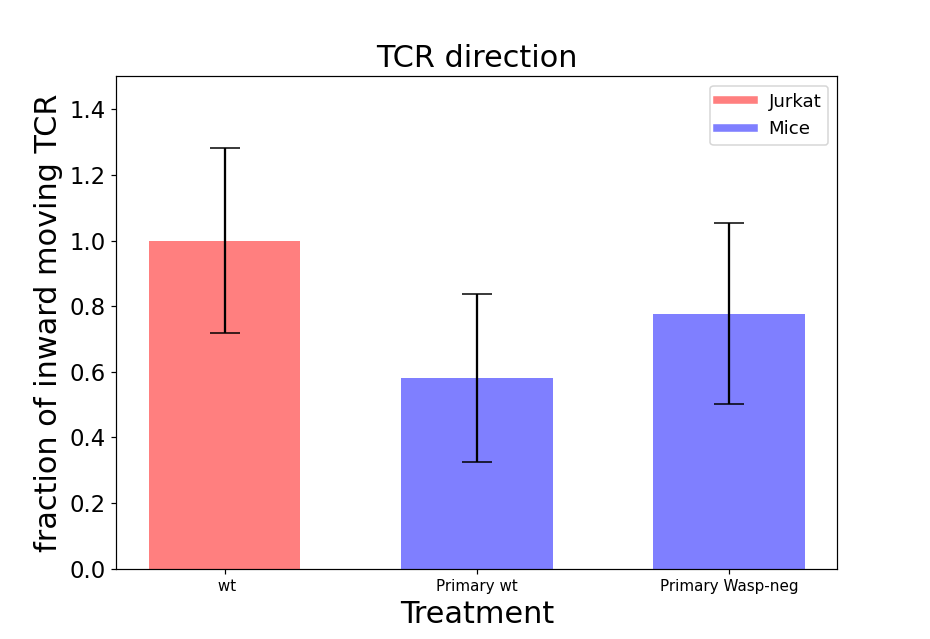

[0 1 2]
[1.0, 0.5819314384761676, 0.7774725274725275]
[0.2806222241392915, 0.25620028671562234, 0.2753297605263121]
P-Value for Jurkat wt vs. Primary Wasp-neg: 1.0
P-Value for Jurkat wt vs. Primary wt: 0.03277466294944107
P-Value for Primary Wasp-neg vs. Primary wt: 0.22208105590371896


In [82]:
###   Normalised ###
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
# Create a dictionary to store the sums and counts for each string
values = ratios
strings = label

# Separate data into two groups (e.g., 'Jurkat' and 'Mouse')
jurkat_values = [value for value, string in zip(values, strings) if string.startswith('Jurkat')]
mouse_values = [value for value, string in zip(values, strings) if string.startswith('Mouse')]


# Create a list of unique treatment groups
treatment_groups = np.unique([label.split("_")[0] for label in strings])

# Initialize dictionaries to store p-values for each pair of groups
p_values = {}

# Calculate p-value for each pair of groups using MU test
for i in range(len(treatment_groups)):
    for j in range(i + 1, len(treatment_groups)):
        group1 = treatment_groups[i]
        group2 = treatment_groups[j]
        
        # Extract values for the two groups
        group1_values = [value for value, label in zip(values, strings) if label.startswith(group1)]
        group2_values = [value for value, label in zip(values, strings) if label.startswith(group2)]
        
        # Calculate the t-statistic and p-value using Student's t-test
        _, p_value = mannwhitneyu(group1_values, group2_values,alternative='two-sided')
        
        # Store the p-value for this pair of groups
        p_values[(group1, group2)] = p_value


# Create your bar plot with error bars as before
x = np.arange(len(treatment_groups))
fig, ax = plt.subplots()

# Create a dictionary to store the sums and counts for each string
sums = {}
counts = {}

# Loop over the values and strings lists, updating the sums and counts in the dictionary
for value, string in zip(values, strings):
    if string not in sums:
        sums[string] = 0
        counts[string] = 0
    sums[string] += value
    counts[string] += 1

# Calculate the averages and standard errors for each string
averages = {}
errors = {}
for string in sums:
    averages[string] = sums[string] / counts[string]
    if string.startswith('Jurkat'):
        jurkat_wt_value = averages[string]
    errors[string] = np.sqrt(np.var([value / jurkat_wt_value for value, string2 in zip(values, strings) if string2 == string])) / 1  # Standard error

# Plot the bar chart with error bars
x = np.arange(len(averages))
fig, ax = plt.subplots(figsize=(7,4))

colors = []
short_labels = []
for string in averages.keys():
    if string.startswith('Jurkat'):
        colors.append('#ff0000')
        short_labels.append(string.replace('Jurkat', ''))
    elif string.startswith('Primary'):
        colors.append('blue')
        short_labels.append(string.replace('Mouse', ''))
    else:
        colors.append('gray')
        short_labels.append(string)

# Normalize values by the Jurkat WT value
normalized_values = [averages[string] / jurkat_wt_value if string.startswith('Jurkat') else averages[string] for string in averages]
normalized_errors = [errors[string] / jurkat_wt_value if string.startswith('Jurkat') else errors[string] for string in errors]

bars = ax.bar(x, normalized_values, yerr=normalized_errors, width=0.6,align='center', alpha=0.5, ecolor='black', capsize=10, color=colors)

ax.set_xticks(x)
ax.set_xticklabels(short_labels)
ax.set_ylabel('fraction of inward moving TCR', fontsize=20, fontname='Arial')
ax.set_xlabel('Treatment', fontsize=20, fontname='Arial')
ax.set_title('TCR direction', fontsize=20, fontname='Arial')
ax.set_ylim(0,1.5)
plt.yticks(fontsize=15, fontname='Arial')

# Create legend handles
red_patch = plt.Line2D([0], [0], color='#ff0000', lw=5, label='Jurkat', alpha=0.5)
blue_patch = plt.Line2D([0], [0], color='blue', lw=5, label='Mice', alpha=0.5)

# Create the plot
ax = plt.gca()

# Set legend font properties
legend_font = FontProperties(family='Arial', size=12)
ax.legend(handles=[red_patch, blue_patch], fontsize=15, title_fontsize=15, prop=legend_font)

plt.show()
print(x)
print(normalized_values)
print(normalized_errors)

# Now, you can print or use the p-values as needed
for group1, group2 in p_values:
    p_value = p_values[(group1, group2)]
    print(f"P-Value for {group1} vs. {group2}: {p_value}")


